### 1.1 PCA scores/cNMF weights with EDS element

In [1]:
import pandas as pd
import numpy as np
from orix import io
import kikuchipy as kp
import ast
from data_preprocessing import get_eds_average, fit_preprocessors, apply_preprocessors, coord_xmap_dict
from sklearn.model_selection import train_test_split
from contrastivemodel import train_and_evaluate, evaluate_contrastive
from visualize_contrastive import visualize_loss_curve, visualize_contrastive_embeddings, visualize_contrastive_embeddings_by_element, visualize_contrastive_embeddings_by_phase

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pca_scores= pd.read_csv('../micro_segmentation/pca_scores1.csv',  header=None, skiprows=1)  # shape (961,10)
pca_scores.iloc[:, 0] = pca_scores.iloc[:, 0].apply(
    lambda s: ast.literal_eval(s) if isinstance(s, str) else s
)

cnmf_w    = pd.read_csv('../micro_segmentation/weight1.csv', header=None, skiprows=1) # shape (961,2)
loc =pca_scores.iloc[:,0]

pca_scores = pca_scores.iloc[:,1:]
cnmf_w = cnmf_w.iloc[:,1:]
pca_scores.columns= [f'PC_{i+1}'   for i in pca_scores.columns]
cnmf_w.columns    = ['cNMF_1', 'cNMF_2']
roi_xrange=(20, 51)
roi_yrange=(5, 36)
edax_binary_path = "../EBSD_scan/Scan3_cropped.up1"
fname_ang = "../EBSD_scan/Scan3_cropped.ang"
xmap = io.load(fname_ang)

xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")
s_edax = kp.load(edax_binary_path)
s_edax.xmap = xmap
coor_dict = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)
roi_eds = get_eds_average(roi_xrange, roi_yrange, s_edax, 'roi')


c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


In [3]:
min(roi_eds[:,-1])

385.0

In [4]:
def normalize_roi_data_vectorized(roi_data):
    row_sums = np.nansum(roi_data, axis=1)

    row_sums[row_sums == 0] = 1
    
    normalized_data = roi_data / row_sums[:, np.newaxis]
    
    all_nan_rows = np.all(np.isnan(roi_data), axis=1)
    normalized_data[all_nan_rows] = 0
    
    return normalized_data
roi_eds = normalize_roi_data_vectorized(roi_eds)
roi_eds = pd.DataFrame(roi_eds, columns=['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe'])
all_data = pd.concat([pca_scores, cnmf_w, roi_eds], axis=1)

In [5]:
train_df, test_df = train_test_split(all_data, test_size=0.2, random_state=42, shuffle=True)

loc_train = loc.loc[train_df.index]
loc_test  = loc.loc[test_df.index]

transformers = fit_preprocessors(
    train_df,
    pca_scale='standard',     
    cnmf_transform='clr',     
    elem_transform='raw' 
)

train_data = apply_preprocessors(train_df, transformers)
test_data  = apply_preprocessors(test_df, transformers)

In [6]:
feature_pc_cols = [c for c in test_data.columns if 'PC_' in c]
feature_cnmf_cols = [c for c in test_data.columns if 'cNMF_' in c]
element_cols = ['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe']


features_pc_np = test_data[feature_pc_cols].values.astype(np.float32)
features_cnmf_np = test_data[feature_cnmf_cols].values.astype(np.float32)
elements_np = test_data[element_cols].values.astype(np.float32)

In [55]:
# Train the model
print("Training PCA Model...")
pca_model, pca_train_losses, pca_test_losses, final_alignment_pca, final_uniformity_pca = train_and_evaluate(
    'pca', train_data, test_data, output_dim=64, latent_dim=128, num_epochs=200, batch_size=128, lr=3e-4,temperature=0.2,learnable_temp=True
)

# print("\nTraining cNMF Model...")
#cnmf_model, cnmf_train_losses, cnmf_test_losses, final_alignment_cnmf, final_uniformity_cnmf = train_and_evaluate(
#    'cnmf', train_data, test_data, output_dim=32, latent_dim=128,num_epochs=200, batch_size=32, lr=1e-3, temperature=0.2
#)

Training PCA Model...
Epoch 1: Alignment=2.2713, Uniformity=-1.2029 | ||zf||=1.000 ||ze||=1.000
Epoch [1/200], PCA - Train Loss: 4.9028, Test Loss: 4.5272, Temp: 0.2000
Epoch [2/200], PCA - Train Loss: 4.8953, Test Loss: 4.5172, Temp: 0.2000
Epoch [3/200], PCA - Train Loss: 4.8885, Test Loss: 4.5152, Temp: 0.2000
Epoch [4/200], PCA - Train Loss: 4.8694, Test Loss: 4.5130, Temp: 0.2000
Epoch [5/200], PCA - Train Loss: 4.8761, Test Loss: 4.5114, Temp: 0.2000
Epoch [6/200], PCA - Train Loss: 4.8647, Test Loss: 4.5105, Temp: 0.2000
Epoch [7/200], PCA - Train Loss: 4.8706, Test Loss: 4.5101, Temp: 0.2000
Epoch [8/200], PCA - Train Loss: 4.8618, Test Loss: 4.5101, Temp: 0.2000
Epoch [9/200], PCA - Train Loss: 4.8650, Test Loss: 4.5094, Temp: 0.2000
Epoch [10/200], PCA - Train Loss: 4.8551, Test Loss: 4.5088, Temp: 0.2000
Epoch 11: Alignment=2.3599, Uniformity=-1.0204 | ||zf||=1.000 ||ze||=1.000
Epoch [11/200], PCA - Train Loss: 4.8592, Test Loss: 4.5084, Temp: 0.2000
Epoch [12/200], PCA - Tr

In [57]:
print("\nTraining cNMF Model...")
cnmf_model, cnmf_train_losses, cnmf_test_losses, final_alignment_cnmf, final_uniformity_cnmf = train_and_evaluate(
    'cnmf', train_data, test_data, output_dim=16, latent_dim=128,num_epochs=200, batch_size=64, lr=3e-4, temperature=0.2
)


Training cNMF Model...


Epoch 1: Alignment=1.6335, Uniformity=-0.7568 | ||zf||=1.000 ||ze||=1.000
Epoch [1/200], CNMF - Train Loss: 4.2892, Test Loss: 3.1257, Temp: 0.2000
Epoch [2/200], CNMF - Train Loss: 4.2065, Test Loss: 3.1211, Temp: 0.2000
Epoch [3/200], CNMF - Train Loss: 4.1813, Test Loss: 3.1189, Temp: 0.2000
Epoch [4/200], CNMF - Train Loss: 4.1782, Test Loss: 3.1191, Temp: 0.2000
Epoch [5/200], CNMF - Train Loss: 4.1744, Test Loss: 3.1188, Temp: 0.2000
Epoch [6/200], CNMF - Train Loss: 4.1724, Test Loss: 3.1187, Temp: 0.2000
Epoch [7/200], CNMF - Train Loss: 4.1696, Test Loss: 3.1188, Temp: 0.2000
Epoch [8/200], CNMF - Train Loss: 4.1659, Test Loss: 3.1186, Temp: 0.2000
Epoch [9/200], CNMF - Train Loss: 4.1706, Test Loss: 3.1183, Temp: 0.2000
Epoch [10/200], CNMF - Train Loss: 4.1694, Test Loss: 3.1184, Temp: 0.2000
Epoch 11: Alignment=1.0635, Uniformity=-0.6217 | ||zf||=1.000 ||ze||=1.000
Epoch [11/200], CNMF - Train Loss: 4.1659, Test Loss: 3.1181, Temp: 0.2000
Epoch [12/200], CNMF - Train Loss: 

[eval] features zf: shape=(193, 64), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.102568, pairwise-dist(mean)=1.148134
[eval] features zf: approx unique rows (4dp) = 193
[eval] elements ze: shape=(193, 64), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.076945, pairwise-dist(mean)=0.837316
[eval] elements ze: approx unique rows (4dp) = 193


[Retrieval] Top-1/5/10: {1: 0.015544041450777202, 5: 0.03626943005181347, 10: 0.07772020725388601} | Median rank: 70.0
[Logit gap] mean/median: -0.1854965090751648 -0.10029727220535278
[Pair cosine distance] mean/std/min/max: 0.48913589119911194 0.23260197043418884 0.13105636835098267 1.3331820964813232
[W&I] Alignment=0.9783  Uniformity=-1.6316


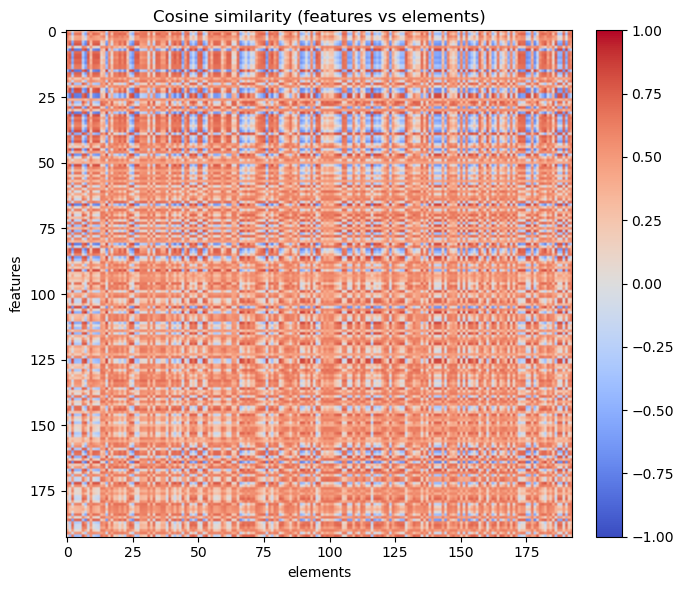

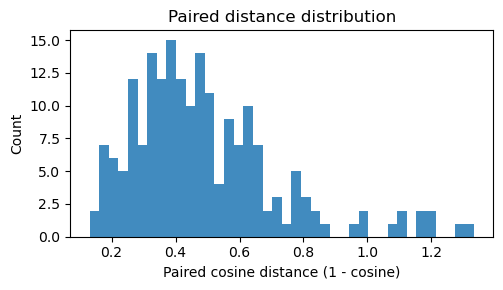

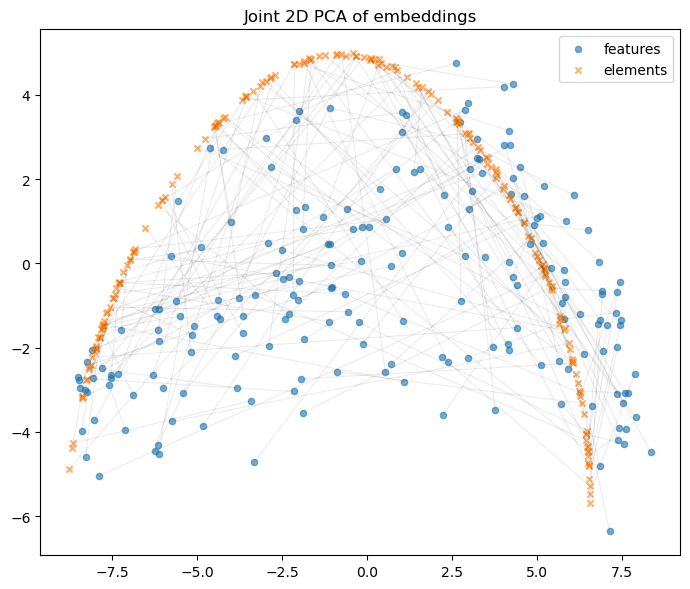

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


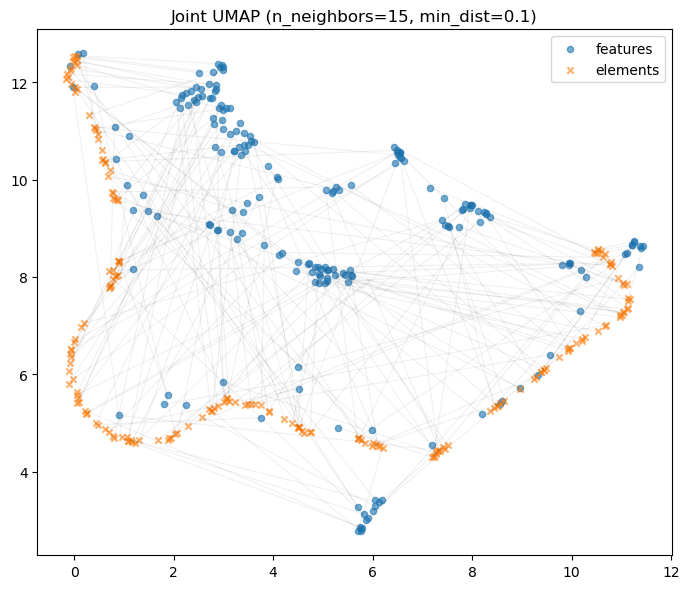

In [56]:
phase_map = {2: 'FeO', 3: 'Fe'}
e_metrics = evaluate_contrastive(pca_model,features_pc_np,elements_np,loc_test,coor_dict,phase_map,True)

[eval] features zf: shape=(193, 16), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.057335, pairwise-dist(mean)=0.274908
[eval] features zf: approx unique rows (4dp) = 189
[eval] elements ze: shape=(193, 16), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.066378, pairwise-dist(mean)=0.335470
[eval] elements ze: approx unique rows (4dp) = 193
[Retrieval] Top-1/5/10: {1: 0.0051813471502590676, 5: 0.04145077720207254, 10: 0.09326424870466321} | Median rank: 67.0
[Logit gap] mean/median: -0.06434853374958038 -0.02847960591316223
[Pair cosine distance] mean/std/min/max: 0.5576028227806091 0.06542173773050308 0.43579328060150146 1.133305311203003
[W&I] Alignment=1.1152  Uniformity=-0.8064


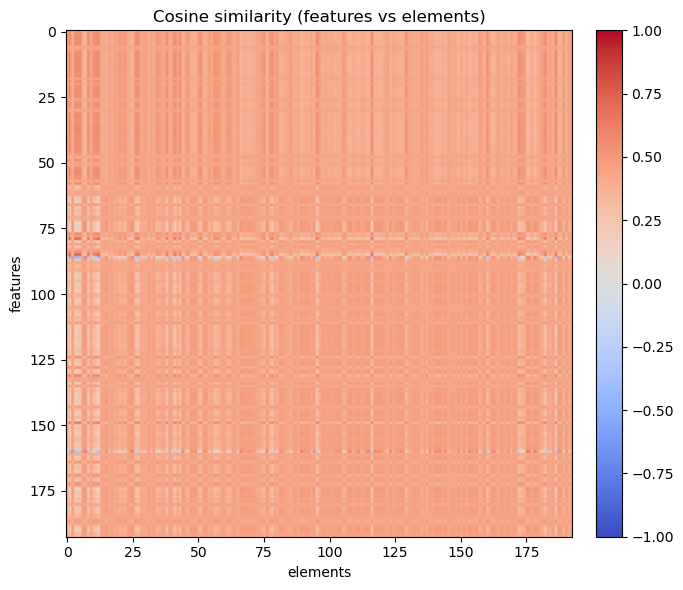

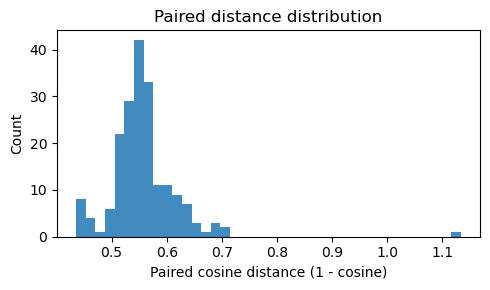

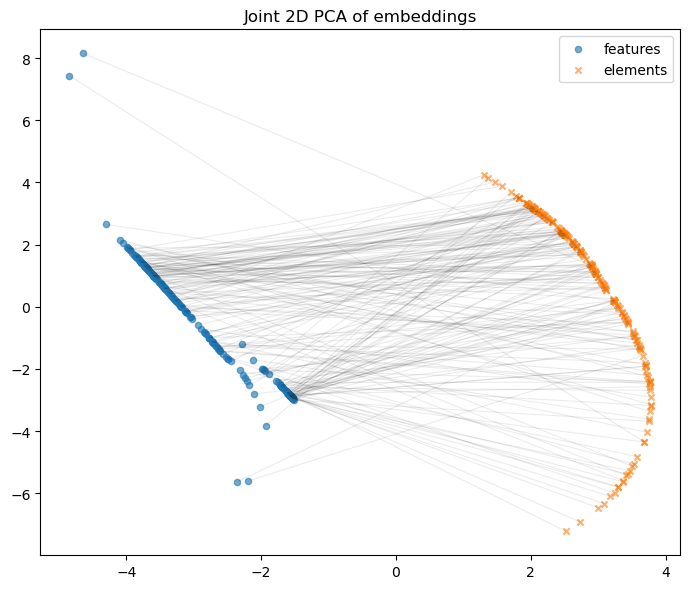

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


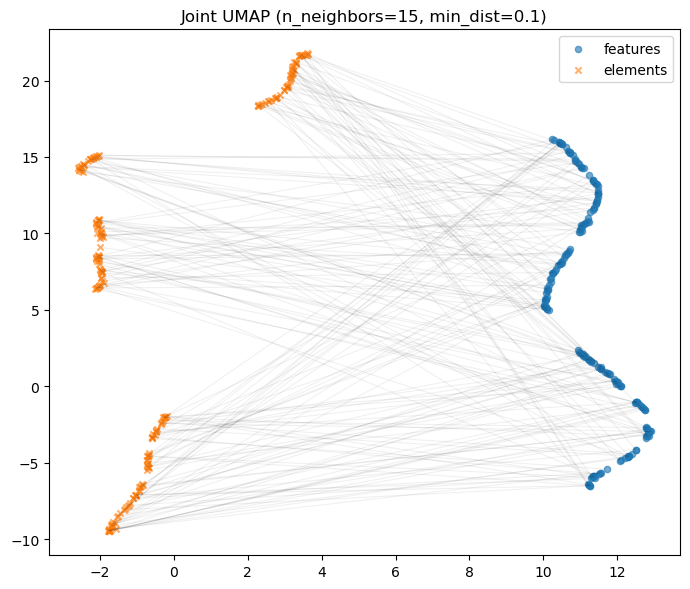

{'similarity': array([[0.4607887 , 0.4172629 , 0.4135499 , ..., 0.3902221 , 0.51768917,
         0.43822092],
        [0.43322593, 0.44122648, 0.441941  , ..., 0.44041952, 0.37531024,
         0.4358311 ],
        [0.43199244, 0.44189003, 0.44278693, ..., 0.44217947, 0.37022305,
         0.43547863],
        ...,
        [0.4697314 , 0.4125755 , 0.40744117, ..., 0.37695992, 0.55220395,
         0.44111452],
        [0.45871472, 0.4278843 , 0.42486823, ..., 0.40465227, 0.48032746,
         0.443253  ],
        [0.47136277, 0.41151863, 0.40610528, ..., 0.37422615, 0.5588972 ,
         0.44154876]], dtype=float32),
 'retrieval': {1: 0.0051813471502590676,
  5: 0.04145077720207254,
  10: 0.09326424870466321},
 'median_rank': 67.0,
 'logit_gap': {'vector': array([-5.71019351e-02, -1.90466642e-03, -1.63778663e-03, -1.05178952e-01,
         -4.68048453e-03, -7.46494532e-03, -5.77700138e-03, -7.48249888e-03,
         -1.61968678e-01, -1.00436866e-01, -9.73287225e-03, -1.17902696e-01,
         

In [58]:
evaluate_contrastive(cnmf_model,features_cnmf_np,elements_np,loc_test,coor_dict,phase_map,True)

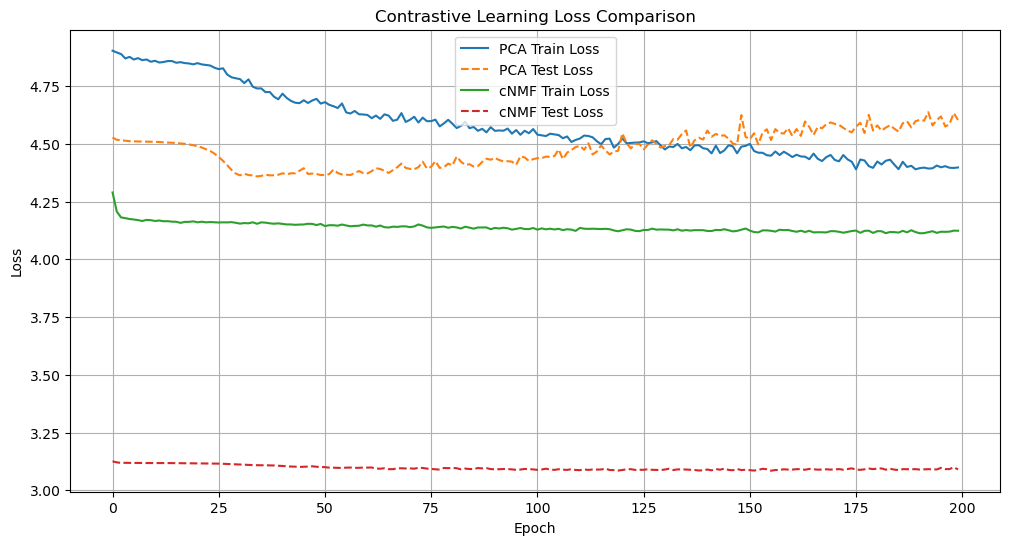

In [59]:
visualize_loss_curve(pca_model, cnmf_model, test_data, pca_train_losses, pca_test_losses, cnmf_train_losses, cnmf_test_losses)

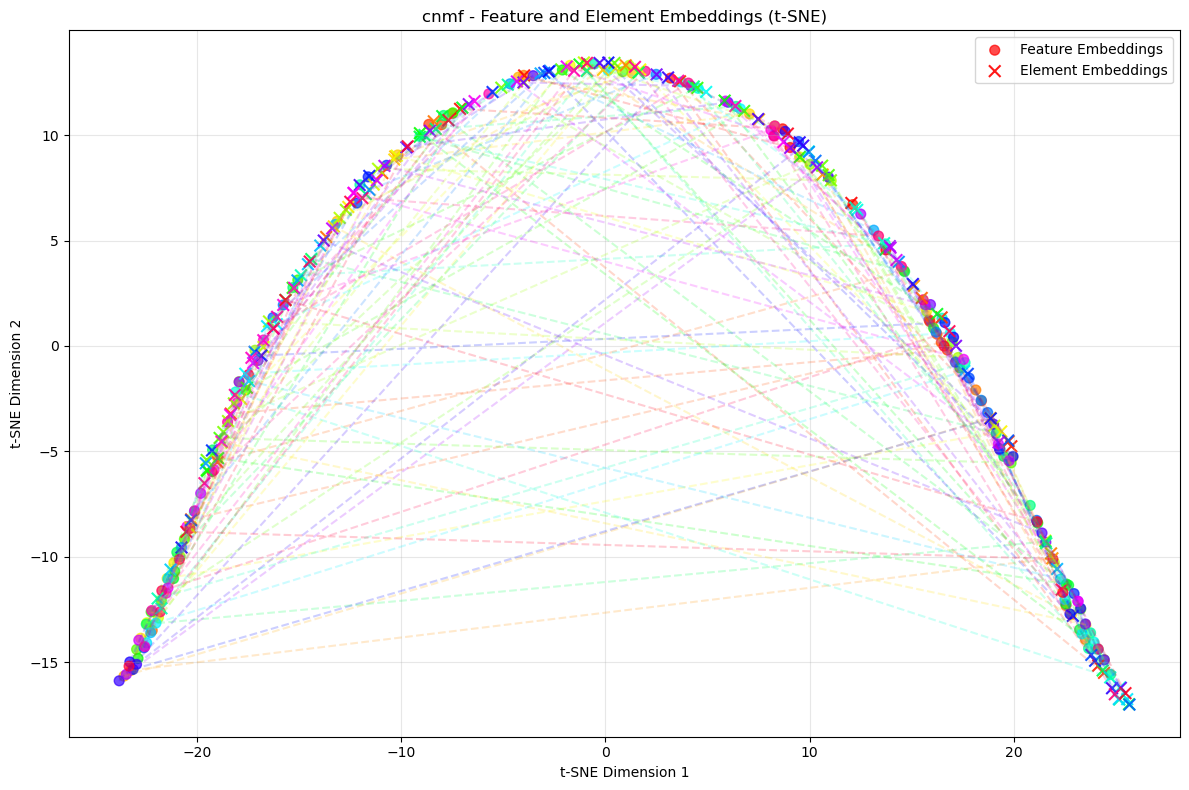

Average distance between feature and element embeddings: 19.5835


In [26]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(cnmf_model, test_data, 'cnmf')


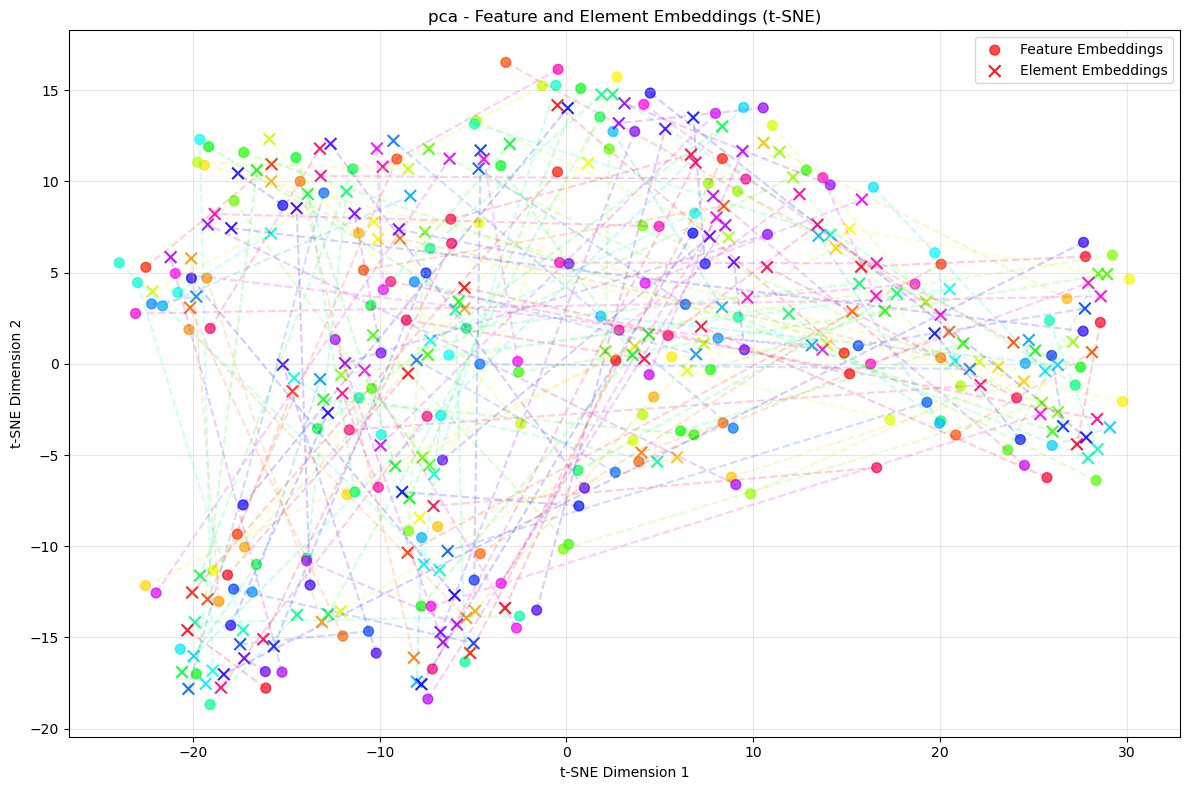

Average distance between feature and element embeddings: 18.4365


In [24]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(pca_model, test_data, 'pca')

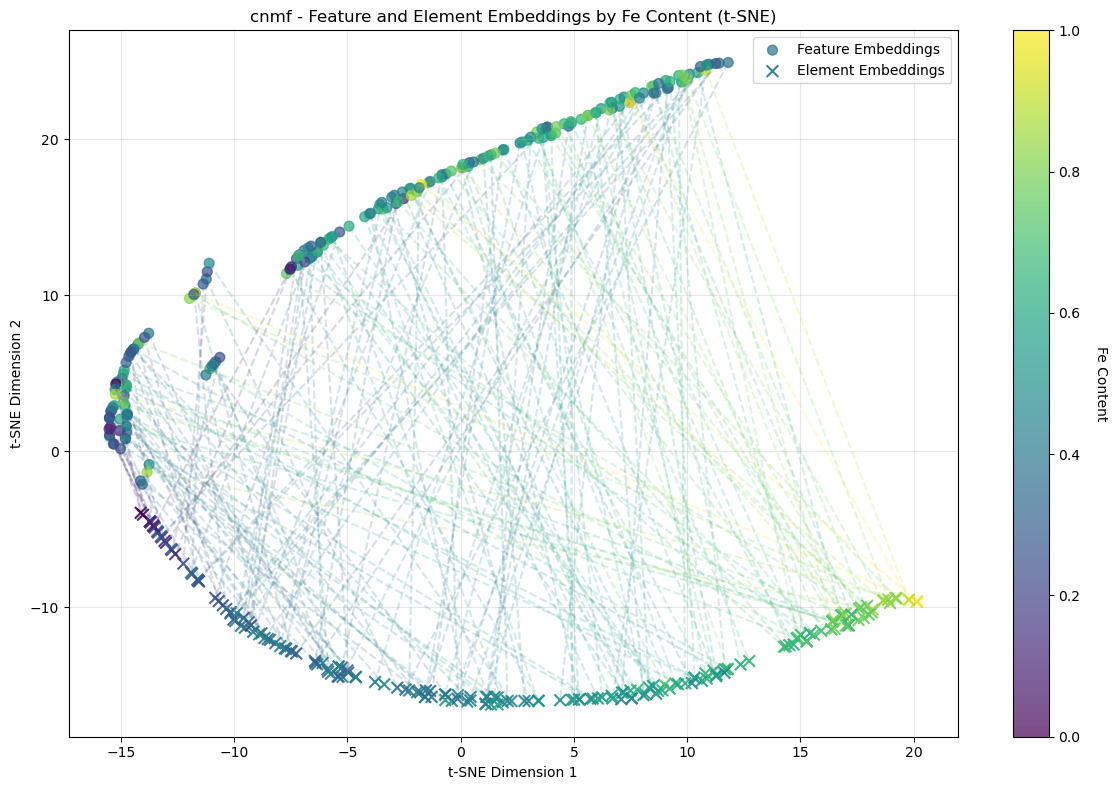

Average distance between feature and element embeddings: 29.5228
Correlation between distance and Fe content: 0.6060


In [12]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(cnmf_model, test_data, 'cnmf', 'Fe')

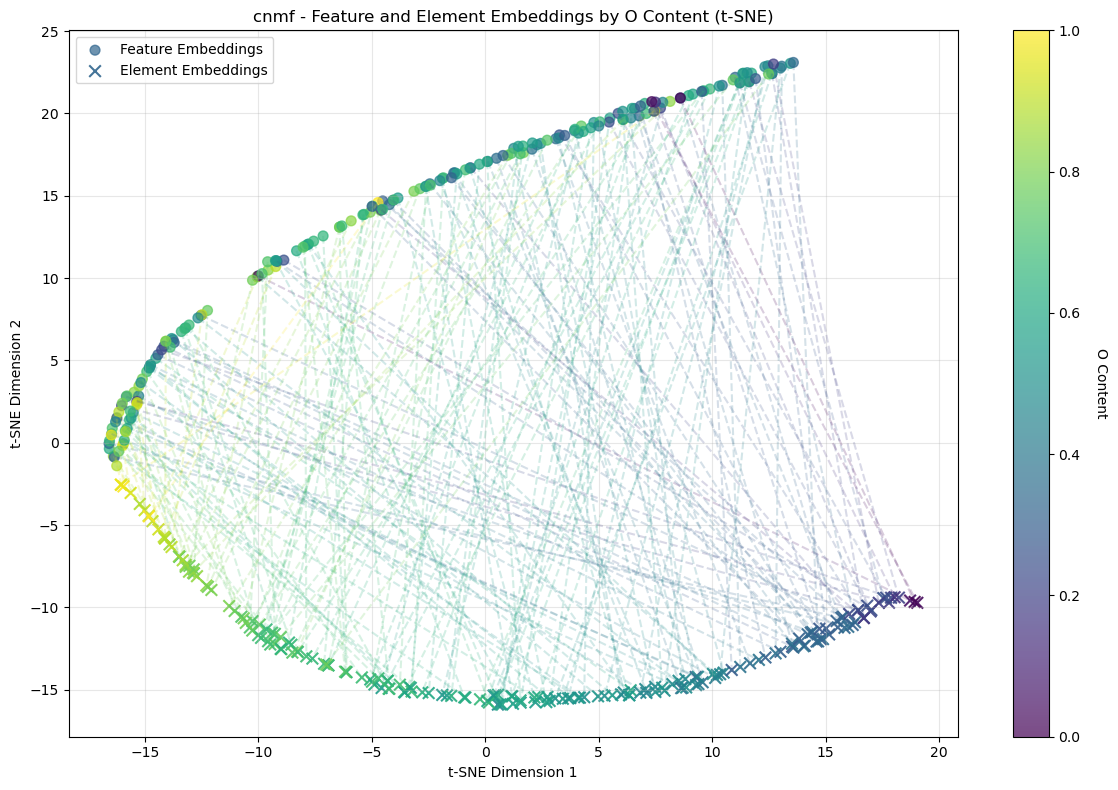

Average distance between feature and element embeddings: 28.8098
Correlation between distance and O content: -0.6064


In [14]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(cnmf_model, test_data, 'cnmf', 'O')

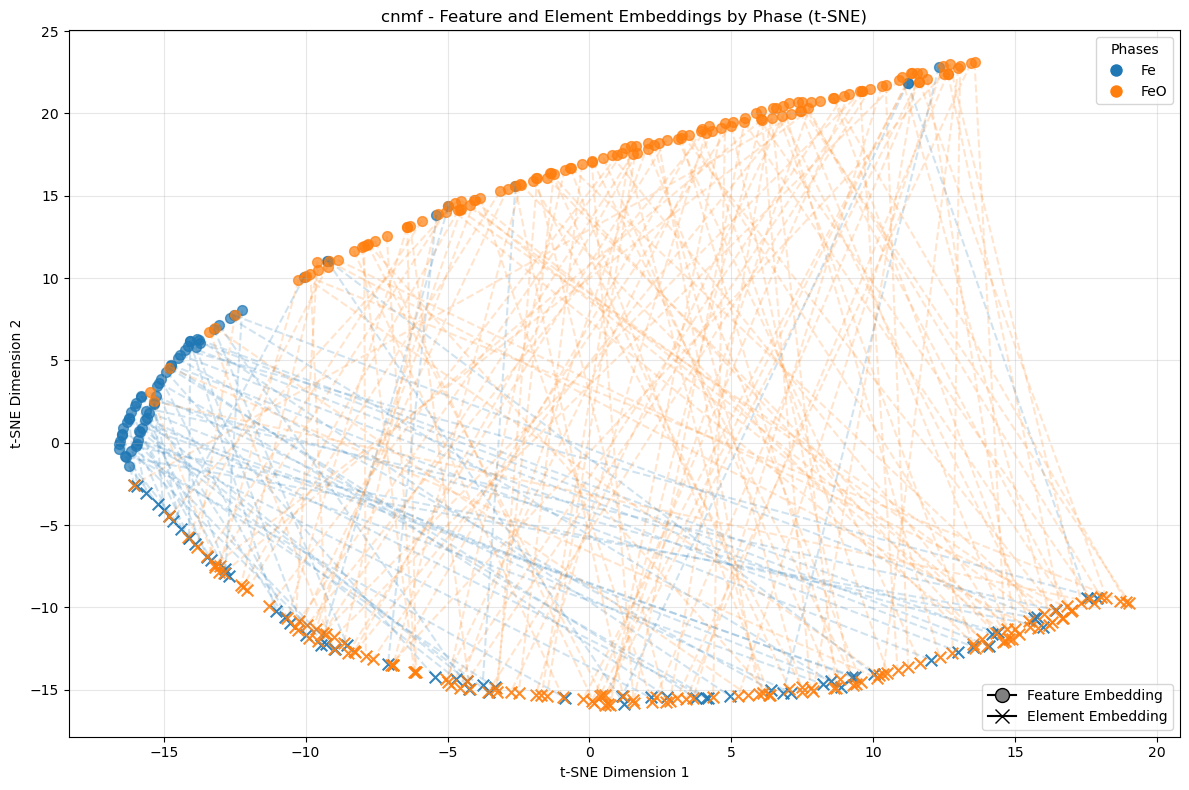

Average distance between feature and element embeddings: 28.8098

Distance by phase:
Fe: 22.2066
FeO: 31.9350


In [15]:
phase_map = {2: 'FeO', 3: 'Fe'}
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(cnmf_model, test_data, loc_testdata, coor_dict, phase_map, 'cnmf')

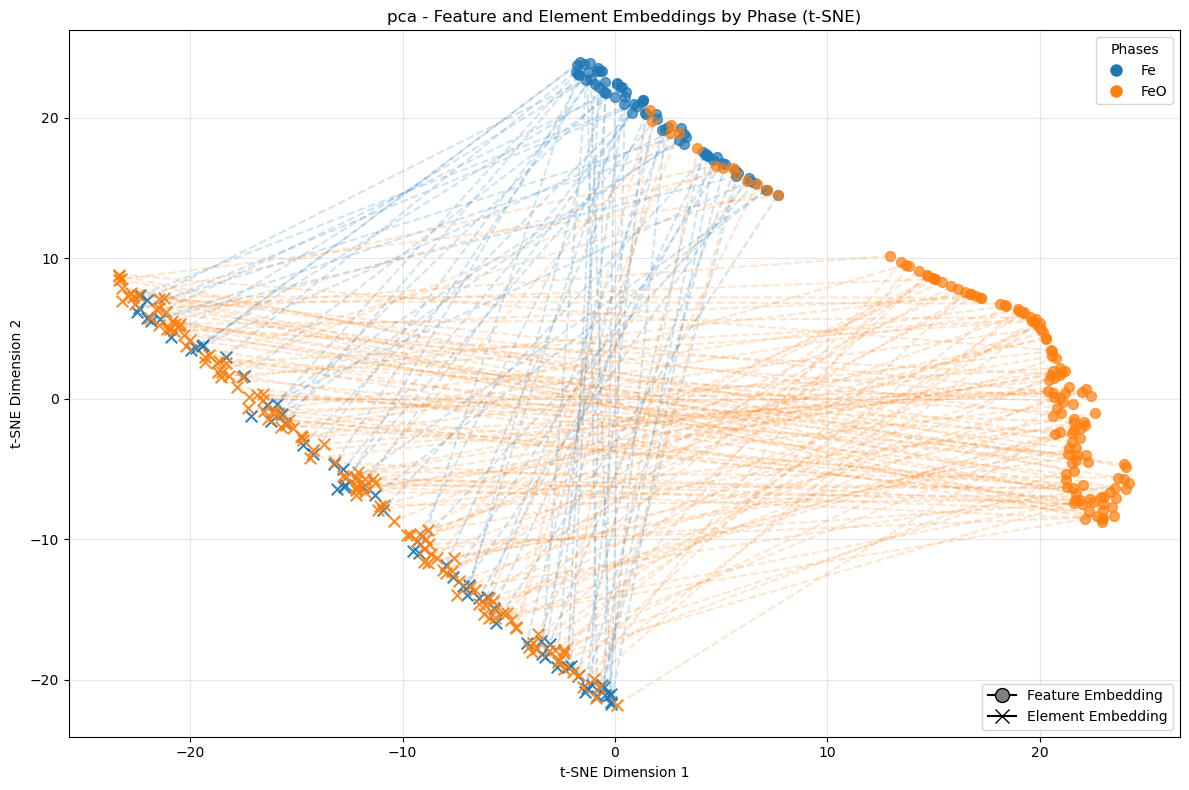

Average distance between feature and element embeddings: 34.9218

Distance by phase:
Fe: 33.1976
FeO: 35.7378


In [13]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(pca_model, test_data, loc_testdata, coor_dict, phase_map, 'pca')

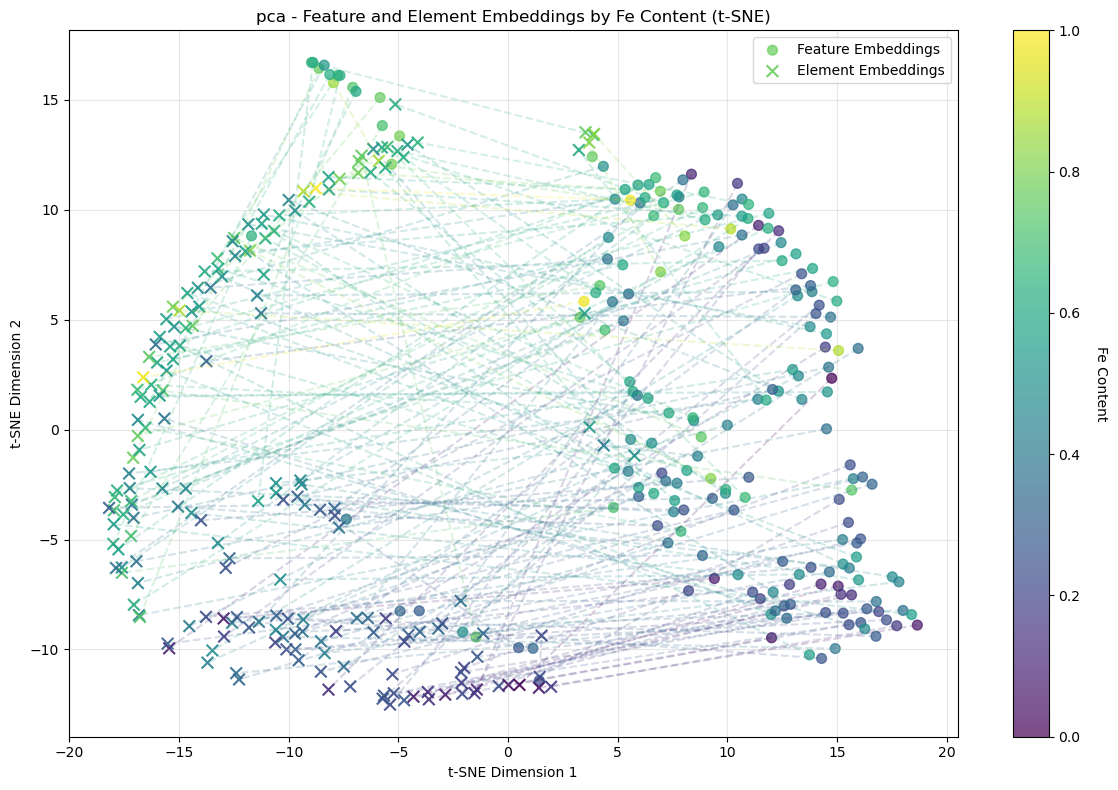

Average distance between feature and element embeddings: 21.4849
Correlation between distance and Fe content: -0.1069


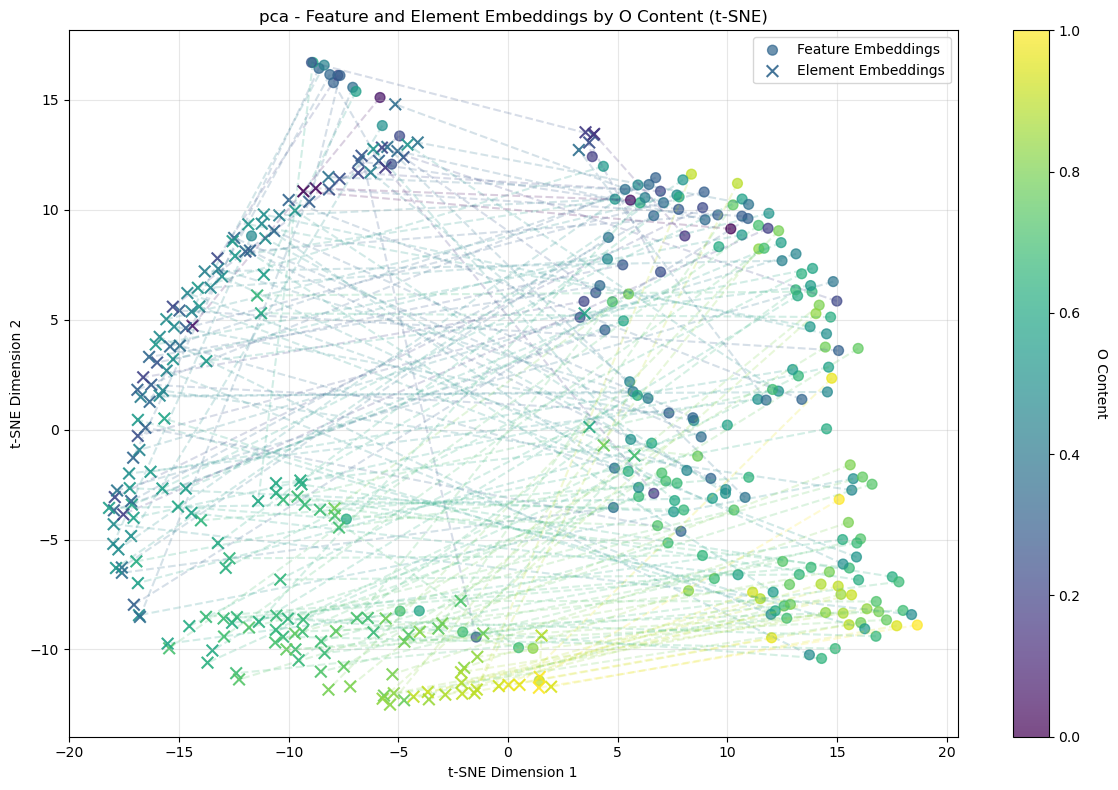

Average distance between feature and element embeddings: 21.4849
Correlation between distance and O content: 0.0334


In [13]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'Fe')
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'O')